In [43]:
import nk_landscape
import gaussian_markov_random_field
import graph_fourier_transform
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import networkx as nx

### Figure 1.
The purpose of Figure 1 is to present an overview of the Gaussian Markov random field metric and how H0 is defined according to the heat diffusion Kernel. 

The below cell defines an arbitrary network graph used as a toy system to demonstrate the heat diffusion kernel transformation and its properties. The sturcutre and signal of this graph is defined using the `nk_landscapes.generate_nk_landscape_amino_acid` function. The graph `G` is a subgraph of the nk exhaustive nk landscape with 1024 randomly sampled nodes. 

In [16]:

#Construct random graph
G = nk_landscape.generate_nk_landscape_amino_acids(N=5,
                                                   K=2,
                                                   amino_acids=[str(val) for val in list(range(13))],
                                                   max_size=1024)


The below cell decomposes the (normalised) graph Laplacian of `G` into its eigenvalues and eigenvectors, which describe the diffusive properties over the graph. The heat kernel attenuates the eigenvalues of the Laplacian. As `t` increases, the attenuation strength increases. 

/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_12026/2726844532.py:27: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, label='t')


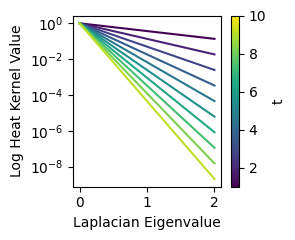

In [18]:
#Decompose the Laplacian spectrum
laplacian, eigenvalues, eigenvectors = gaussian_markov_random_field.compute_laplacian_spectrum(G=G)
epsilon = 1e-8 
t_range = np.linspace(1, 10, 10)
colors = cm.viridis(np.linspace(0, 1, len(t_range)+1))

plt.figure(figsize=(3,2.5))

for t, color in zip(t_range, colors):

    #Compute the heat kernel values at timestep = t
    lambda_adjusted = eigenvalues + epsilon
    h_i = np.exp(-t * lambda_adjusted)

    plt.plot(eigenvalues, h_i, color=color, label=f't={t:.1f}')


plt.xlabel('Laplacian Eigenvalue')
plt.ylabel('Log Heat Kernel Value')

#plot the linearised log transformation
plt.yscale('log')

norm = mcolors.Normalize(vmin=t_range.min(), vmax=t_range.max())
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([]) 
cbar = plt.colorbar(sm, label='t')

plt.tight_layout()
plt.savefig('../figures/figure_1/panel_a.pdf')
plt.show()

The cell below computes the graph fourier transform of `G` and shows show the heat kernel attenuates high frequency energies.

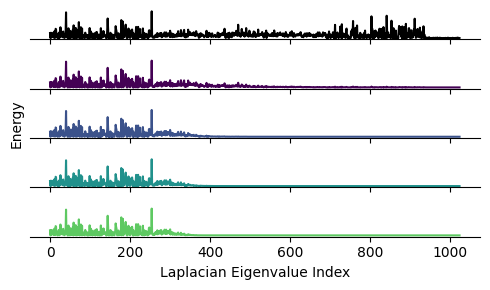

In [17]:

t_range = np.linspace(1, 10, 4)
colors = cm.viridis(np.linspace(0, 1, 5))

total_plots = len(t_range) + 1
fig, axes = plt.subplots(total_plots, 1, figsize=(5, 3), sharex=True)

# Fit the variance to scale the heat kernel
signal = [node[1]['value'] for node in G.nodes(data=True)]
sigma_squared = np.var(signal, ddof=1)

# Perform graph Fourier transform
f_hat = graph_fourier_transform.graph_fourier_transform(G=G, return_norm=False)

# Compute the spectral energies of `G`
f_hat_energies = f_hat ** 2

# Plot original spectral energies
axes[0].plot(f_hat_energies, color='black')
axes[0].grid(False)
axes[0].spines['right'].set_visible(False)
axes[0].spines['top'].set_visible(False)
axes[0].tick_params(axis='y', which='both', left=False, labelleft=False)
axes[0].spines['left'].set_visible(False)

# Iterate through t values and plot modified spectral energies
for idx, (t, color) in enumerate(zip(t_range, colors)):

    if idx == 1:
        axes[idx + 1].set_ylabel('Energy')

    # Compute the heat kernel values at timestep t
    lambda_adjusted = eigenvalues + epsilon
    h_i = np.exp(-t * lambda_adjusted)

    # Scale the energies of `G` according to the heat kernel eigenvalues
    f_hat_modified = h_i * f_hat

    # Compute the spectral energies of `G` with heat diffusion
    f_hat_modified_energies = np.abs(f_hat_modified) ** 2

    axes[idx + 1].plot(f_hat_modified_energies, color=color)
    axes[idx + 1].grid(False)
    axes[idx + 1].spines['right'].set_visible(False)
    axes[idx + 1].spines['top'].set_visible(False)
    axes[idx + 1].spines['left'].set_visible(False)
    axes[idx + 1].tick_params(axis='y', which='both', left=False, labelleft=False)

axes[-1].set_xlabel('Laplacian Eigenvalue Index')

plt.tight_layout()
plt.savefig('../figures/figure_1/panel_b.pdf')
plt.show()



The below cell computes and plots the covariance matrix of the Gaussian Markov random field using the `gaussian_markov_random_field.generate_variance` function. This describes the covariance / structural correlation between positions in the graph at different timestep values `t`.

/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_12026/3720220683.py:55: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


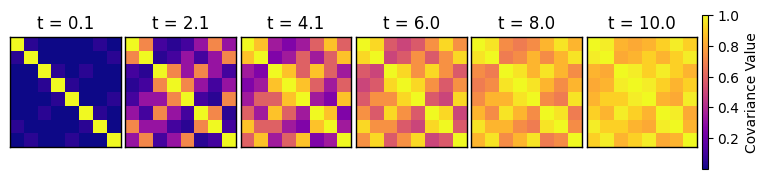

In [109]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
from matplotlib import gridspec

n = 8
G = nx.random_regular_graph(d=int(np.sqrt(n)), n=n)

t_range = np.linspace(0.1, 10, 6)

sigma_h0_list = []
for t in t_range:
    variances_H0, sigma_h0 = gaussian_markov_random_field.compute_variances_H0(
        sigma_squared=1,
        t=t,
        G=G
    )
    sigma_h0_list.append(sigma_h0)

vmin = min(sigma.min() for sigma in sigma_h0_list)
vmax = max(sigma.max() for sigma in sigma_h0_list)

num_t = len(t_range)

fig = plt.figure(figsize=(9, 2))
gs = gridspec.GridSpec(1, num_t + 1, width_ratios=[1]*num_t + [0.05], wspace=0.05)

axes = []
for idx in range(num_t):
    ax = fig.add_subplot(gs[idx])
    axes.append(ax)

for idx, (ax, sigma_h0, t) in enumerate(zip(axes, sigma_h0_list, t_range)):
    sns.heatmap(sigma_h0, ax=ax, vmin=vmin, vmax=vmax, cmap='plasma',
                cbar=False, xticklabels=False, yticklabels=False)
    ax.set_aspect('equal')
    ax.set_title(f't = {t:.1f}')
    ax.set_xlabel('')
    ax.set_ylabel('')

    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_edgecolor('black')
        spine.set_linewidth(1)

cbar_ax = fig.add_subplot(gs[-1])
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap='plasma', norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, cax=cbar_ax)
cbar.set_label('Covariance Value')

#plt.subplots_adjust(left=0.05, right=0.95, top=0.85, bottom=0.15)
plt.tight_layout()
plt.savefig('../figures/figure_1/panel_c.pdf')
plt.show()
